In [7]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
import warnings

warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")

In [10]:
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import datetime
import yfinance as yf
pdr.get_data_yahoo = pdr.get_data_yahoo

## FETCH DATA

In [129]:
# Download historical data
adobe = yf.download("ADBE", start="2010-01-01", end="2025-01-01")
microsoft = yf.download("MSFT", start="2010-01-01", end="2025-01-01")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## GENERATE FEATURES

In [130]:
# Combine data using merge
data = pd.merge(adobe['Close'], microsoft['Close'], left_index=True, right_index=True, suffixes=('_adobe', '_microsoft'))

# Rename columns for clarity
data.columns = ['adobe_close', 'microsoft_close']


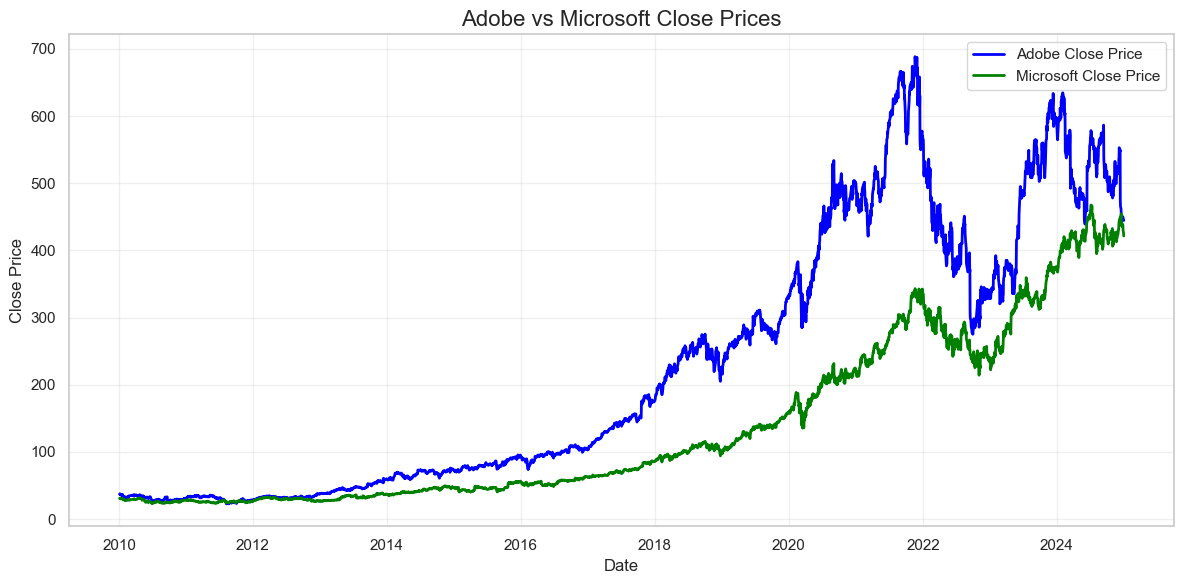

In [131]:
import matplotlib.pyplot as plt

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['adobe_close'], label='Adobe Close Price', color='blue', linewidth=2)
plt.plot(data.index, data['microsoft_close'], label='Microsoft Close Price', color='green', linewidth=2)

# Customize the plot
plt.title('Adobe vs Microsoft Close Prices', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

# Show the plot
plt.show()


In [132]:
data['price_ratio'] = data['adobe_close'] / data['microsoft_close']

# Moving Averages
data['ma_5'] = data['price_ratio'].rolling(5).mean()
data['ma_20'] = data['price_ratio'].rolling(20).mean()
data['ma_60'] = data['price_ratio'].rolling(10).mean()

# Rate of Change (ROC)
data['roc'] = data['price_ratio'].pct_change(periods=5)

# Volatility (Standard Deviation)
data['volatility'] = data['price_ratio'].rolling(20).std()

# # Lag Features
for lag in range(1, 3):
    data[f'lag_{lag}'] = data['price_ratio'].shift(lag)

# Drop NaN values caused by feature engineering
data = data.dropna()

# Show the resulting dataframe
print(data)


            adobe_close  microsoft_close  price_ratio      ma_5     ma_20  \
Date                                                                        
2010-02-01    32.480000        28.410000     1.143259  1.136968  1.177897   
2010-02-02    32.980000        28.459999     1.158819  1.138630  1.175919   
2010-02-03    32.980000        28.629999     1.151939  1.145627  1.172631   
2010-02-04    32.240002        27.840000     1.158046  1.151653  1.169402   
2010-02-05    32.770000        28.020000     1.169522  1.156317  1.167304   
...                 ...              ...          ...       ...       ...   
2024-12-24   447.940002       439.329987     1.019598  1.015998  1.131606   
2024-12-26   450.160004       438.109985     1.027505  1.019707  1.121613   
2024-12-27   446.480011       430.529999     1.037047  1.026952  1.112746   
2024-12-30   445.799988       424.829987     1.049361  1.031982  1.104295   
2024-12-31   444.679993       421.500000     1.054994  1.037701  1.097158   

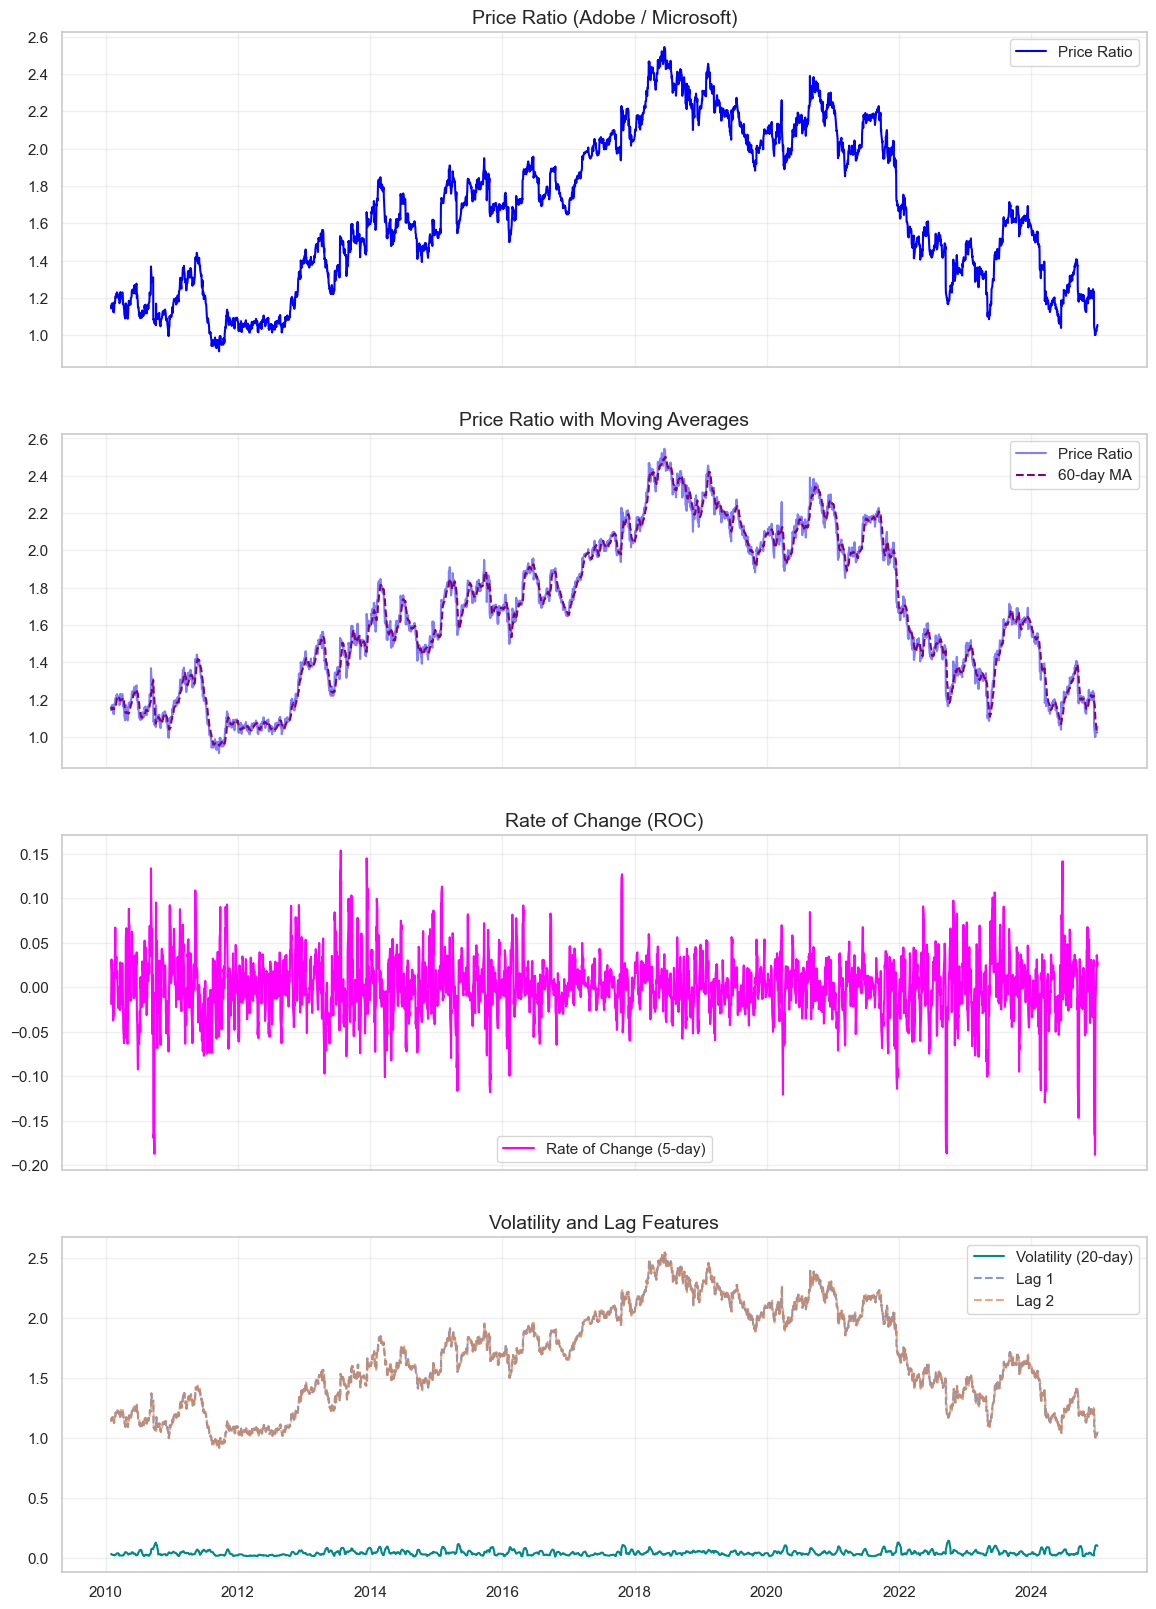

In [133]:
import matplotlib.pyplot as plt

# Create a figure with multiple subplots
fig, axes = plt.subplots(4, 1, figsize=(14, 20), sharex=True)

# 1. Price Ratio
axes[0].plot(data.index, data['price_ratio'], label='Price Ratio', color='blue', linewidth=1.5)
axes[0].set_title('Price Ratio (Adobe / Microsoft)', fontsize=14)
axes[0].legend()
axes[0].grid(alpha=0.3)


# 3. Moving Averages
axes[1].plot(data.index, data['price_ratio'], label='Price Ratio', color='blue', alpha=0.5)
# axes[1].plot(data.index, data['ma_5'], label='5-day MA', color='green', linestyle='--', linewidth=1.5)
# axes[1].plot(data.index, data['ma_20'], label='20-day MA', color='red', linestyle='--', linewidth=1.5)
axes[1].plot(data.index, data['ma_60'], label='60-day MA', color='purple', linestyle='--', linewidth=1.5)
axes[1].set_title('Price Ratio with Moving Averages', fontsize=14)
axes[1].legend()
axes[1].grid(alpha=0.3)

# # 4. Rate of Change (ROC)
axes[2].plot(data.index, data['roc'], label='Rate of Change (5-day)', color='magenta', linewidth=1.5)
axes[2].set_title('Rate of Change (ROC)', fontsize=14)
axes[2].legend()
axes[2].grid(alpha=0.3)

# # 5. Volatility and Lags
axes[3].plot(data.index, data['volatility'], label='Volatility (20-day)', color='darkcyan', linewidth=1.5)
for lag in range(1, 3):
    axes[3].plot(data.index, data[f'lag_{lag}'], label=f'Lag {lag}', linestyle='--', alpha=0.7)
axes[3].set_title('Volatility and Lag Features', fontsize=14)
axes[3].legend()
axes[3].grid(alpha=0.3)

# # Adjust layout and show the plot
# plt.tight_layout()
# plt.show()


## FINDING THE BEST TRAINING PERIOD

Best Period for Training:
start_date     2015-10-30 00:00:00
end_date       2018-10-30 00:00:00
coint_score              -3.336008
p_value                   0.049972
Name: 203, dtype: object


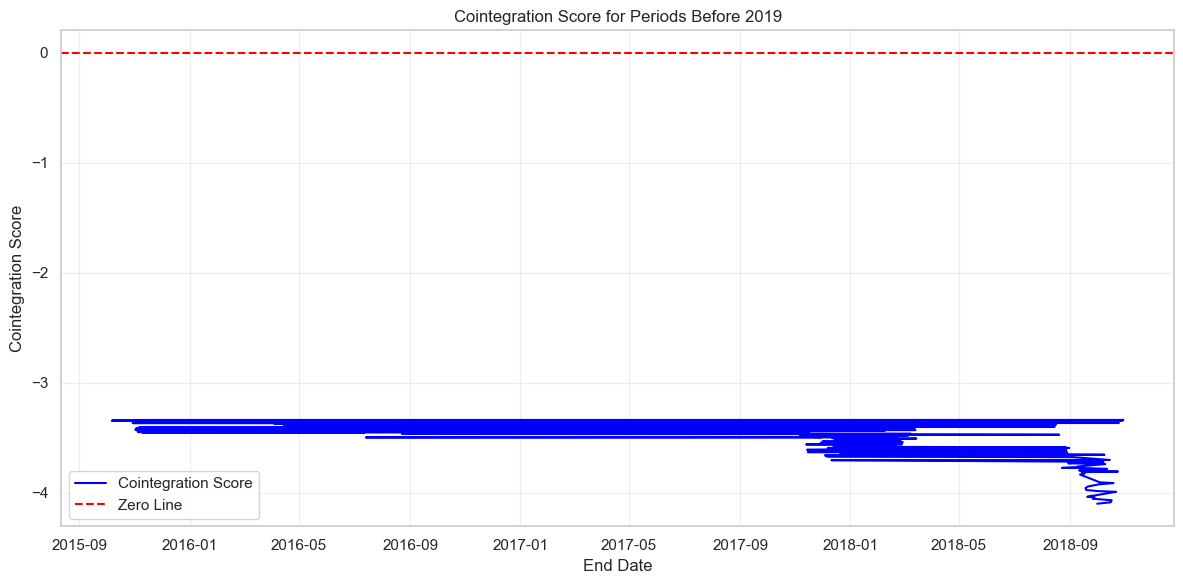

In [122]:
def engle_granger_coint_test(series1, series2):
    score, p_value, _ = coint(series1, series2)
    return score, p_value

def find_best_training_period(data, window_size, min_p_value=0.05):
    start_dates = []
    end_dates = []
    coint_scores = []
    p_values = []

    for i in range(len(data) - window_size + 1):
        window_data = data.iloc[i:i + window_size]
        adobe_close = window_data['adobe_close']
        microsoft_close = window_data['microsoft_close']

        score, p_value = engle_granger_coint_test(adobe_close, microsoft_close)
        if p_value < min_p_value:  # Only consider significant periods
            start_dates.append(window_data.index[0])
            end_dates.append(window_data.index[-1])
            coint_scores.append(score)
            p_values.append(p_value)

    # Create a results DataFrame
    result_df = pd.DataFrame({
        'start_date': start_dates,
        'end_date': end_dates,
        'coint_score': coint_scores,
        'p_value': p_values
    })

    # Sort by the highest cointegration score
    result_df = result_df.sort_values(by='coint_score', ascending=False)
    return result_df

window_size = 756 #Apply sliding window analysis with a minimum of 3 years (756 trading days)- this is just one use, can be any other number also
results = find_best_training_period(data, window_size)

if not results.empty:
    best_period = results.iloc[0]
    print("Best Period for Training:")
    print(best_period)
else:
    print("No significant cointegration periods found before 2019.")

# Step 5: Plot the cointegration scores for periods before 2019
plt.figure(figsize=(12, 6))
plt.plot(results['end_date'], results['coint_score'], label='Cointegration Score', color='blue')
plt.axhline(0, color='red', linestyle='--', label='Zero Line')
plt.title('Cointegration Score for Periods Before 2019')
plt.xlabel('End Date')
plt.ylabel('Cointegration Score')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [134]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Extract the best period from the cointegration analysis
best_start_date = best_period['start_date']
best_end_date = best_period['end_date']

# Filter the data for the best training period
train_data = data.loc[best_start_date:best_end_date]

# Use the remaining data after the training period as test data
test_data = data.loc[best_end_date:].iloc[1:]  # Start after the best training period

# Define features and target for training and testing
features = [col for col in data.columns if col not in ['price_ratio', 'adobe_close', 'microsoft_close']]
X_train = train_data[features]
y_train = train_data['price_ratio']
X_test = test_data[features]
y_test = test_data['price_ratio']

In [135]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the model
model = RandomForestRegressor(random_state=42)

# Train the model on the training data
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [136]:
from sklearn.metrics import mean_squared_error

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model using Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error on Test Set: {mse}')


Mean Squared Error on Test Set: 0.026749175515835538


In [137]:
y_pred_train = model.predict(X_train) 


## TRAIN SET VIZ

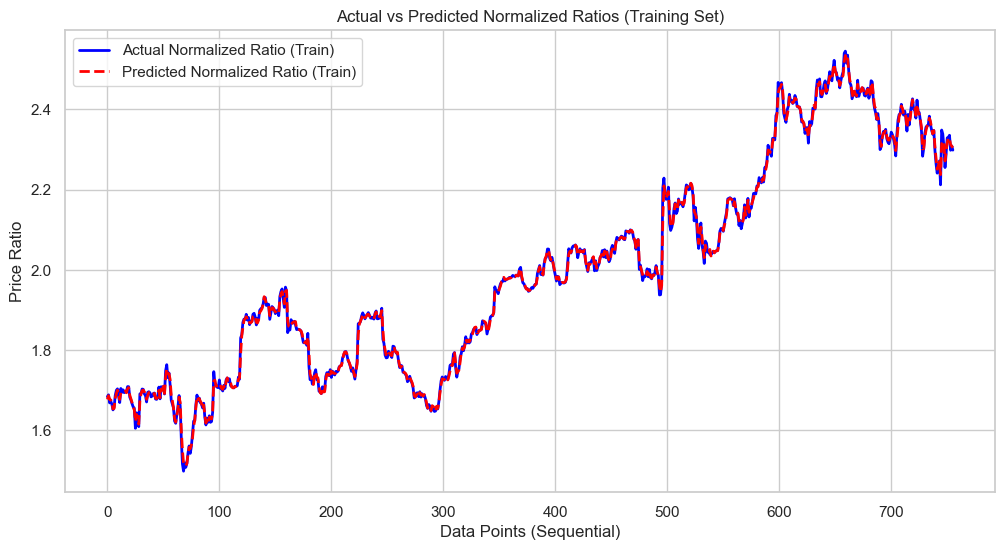

In [138]:
import matplotlib.pyplot as plt

# Predict on the training set
model = RandomForestRegressor()  # Replace with your trained model
model.fit(X_train, y_train)      # Ensure your model is trained
y_pred_train = model.predict(X_train)

# Create a clean plot
plt.figure(figsize=(12, 6))

# Plot actual and predicted normalized ratios for the training set
plt.plot(range(len(y_train)), y_train, label='Actual Normalized Ratio (Train)', color='blue', linestyle='-', linewidth=2)
plt.plot(range(len(y_pred_train)), y_pred_train, label='Predicted Normalized Ratio (Train)', color='red', linestyle='--', linewidth=2)

# Add labels, title, and legend
plt.title('Actual vs Predicted Normalized Ratios (Training Set)')
plt.xlabel('Data Points (Sequential)')
plt.ylabel('Price Ratio')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


## TEST SET VIZ

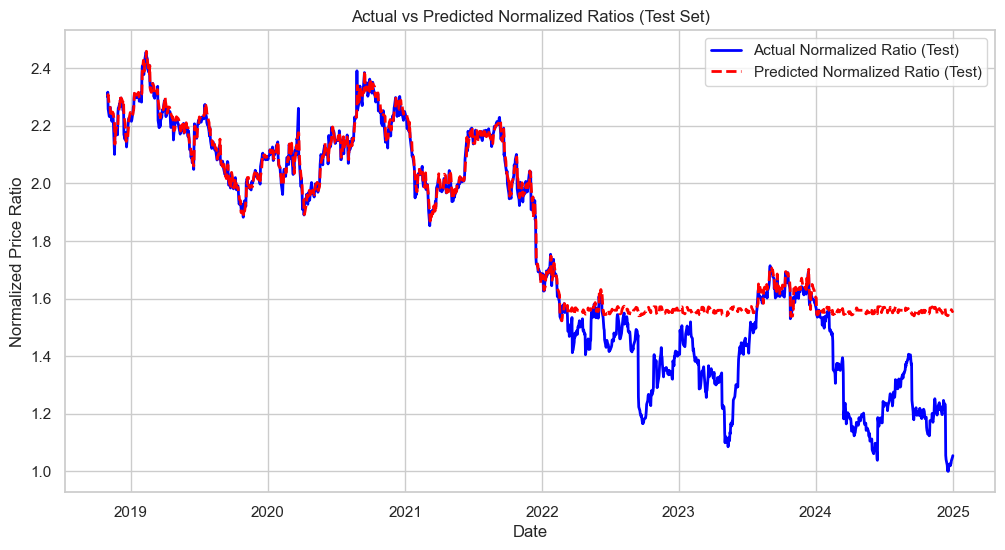

In [139]:
import matplotlib.pyplot as plt

# Plot the predicted vs. actual normalized ratios
plt.figure(figsize=(12, 6))

# Plot actual and predicted values for the test set
plt.plot(test_data.index, y_test, label='Actual Normalized Ratio (Test)', color='blue', linestyle='-', linewidth=2)
plt.plot(test_data.index, y_pred, label='Predicted Normalized Ratio (Test)', color='red', linestyle='--', linewidth=2)

# Adding labels and title
plt.title('Actual vs Predicted Normalized Ratios (Test Set)')
plt.xlabel('Date')
plt.ylabel('Normalized Price Ratio')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


## OTHER TESTS 

In [140]:
import statsmodels.api as sm
import pandas as pd
from sklearn.metrics import mean_squared_error

# Initialize an empty dataframe for metrics (or use your existing ones)
metric_table_train = pd.DataFrame(columns=['R-squared', 'MSE', 'Durbin-Watson', 'Jarque-Bera', 'JB P-value'])
metric_table_test = pd.DataFrame(columns=['R-squared', 'MSE', 'Durbin-Watson', 'Jarque-Bera', 'JB P-value'])

# Train metrics
r2_train = model.score(X_train, y_train)
y_train_pred = model.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred)

# Test metrics
r2_test = model.score(X_test, y_test)
y_test_pred = model.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)

# Calculate residuals
residuals_train = y_train - y_train_pred
residuals_test = y_test - y_test_pred

# Perform Durbin-Watson and Jarque-Bera tests
durbin_watson_stat_train = sm.stats.durbin_watson(residuals_train)
jb_stat_train, jb_p_value_train, _, _ = sm.stats.jarque_bera(residuals_train)

durbin_watson_stat_test = sm.stats.durbin_watson(residuals_test)
jb_stat_test, jb_p_value_test, _, _ = sm.stats.jarque_bera(residuals_test)

# Algorithm name (could be the model name or any identifier)
algorithm_name = 'RandomForestRegressor'

# Update metric tables for training data
metric_table_train.at[algorithm_name, 'R-squared'] = r2_train
metric_table_train.at[algorithm_name, 'MSE'] = mse_train
metric_table_train.at[algorithm_name, 'Durbin-Watson'] = durbin_watson_stat_train
metric_table_train.at[algorithm_name, 'Jarque-Bera'] = jb_stat_train
metric_table_train.at[algorithm_name, 'JB P-value'] = jb_p_value_train

# Update metric tables for testing data
metric_table_test.at[algorithm_name, 'R-squared'] = r2_test
metric_table_test.at[algorithm_name, 'MSE'] = mse_test
metric_table_test.at[algorithm_name, 'Durbin-Watson'] = durbin_watson_stat_test
metric_table_test.at[algorithm_name, 'Jarque-Bera'] = jb_stat_test
metric_table_test.at[algorithm_name, 'JB P-value'] = jb_p_value_test

# Print the updated metric tables
print("Training Metrics:\n", metric_table_train)
print("\nTesting Metrics:\n", metric_table_test)


Training Metrics:
                       R-squared       MSE Durbin-Watson  Jarque-Bera  \
RandomForestRegressor  0.999151  0.000059      1.757001  8044.358977   

                      JB P-value  
RandomForestRegressor        0.0  

Testing Metrics:
                       R-squared       MSE Durbin-Watson Jarque-Bera JB P-value
RandomForestRegressor  0.827294  0.026568      0.025791  560.722892        0.0


In [141]:
# Generate predictions for trading simulation using the test data
test_data['predicted_ratio'] = model.predict(X_test)

print(test_data)


            adobe_close  microsoft_close  price_ratio      ma_5     ma_20  \
Date                                                                        
2018-10-31   245.759995       106.809998     2.300908  2.308263  2.298218   
2018-11-01   245.279999       105.919998     2.315710  2.304333  2.297101   
2018-11-02   239.639999       106.160004     2.257347  2.296191  2.292595   
2018-11-05   239.889999       107.510002     2.231327  2.280733  2.289281   
2018-11-06   240.559998       107.720001     2.233197  2.267698  2.287740   
...                 ...              ...          ...       ...       ...   
2024-12-24   447.940002       439.329987     1.019598  1.015998  1.131606   
2024-12-26   450.160004       438.109985     1.027505  1.019707  1.121613   
2024-12-27   446.480011       430.529999     1.037047  1.026952  1.112746   
2024-12-30   445.799988       424.829987     1.049361  1.031982  1.104295   
2024-12-31   444.679993       421.500000     1.054994  1.037701  1.097158   

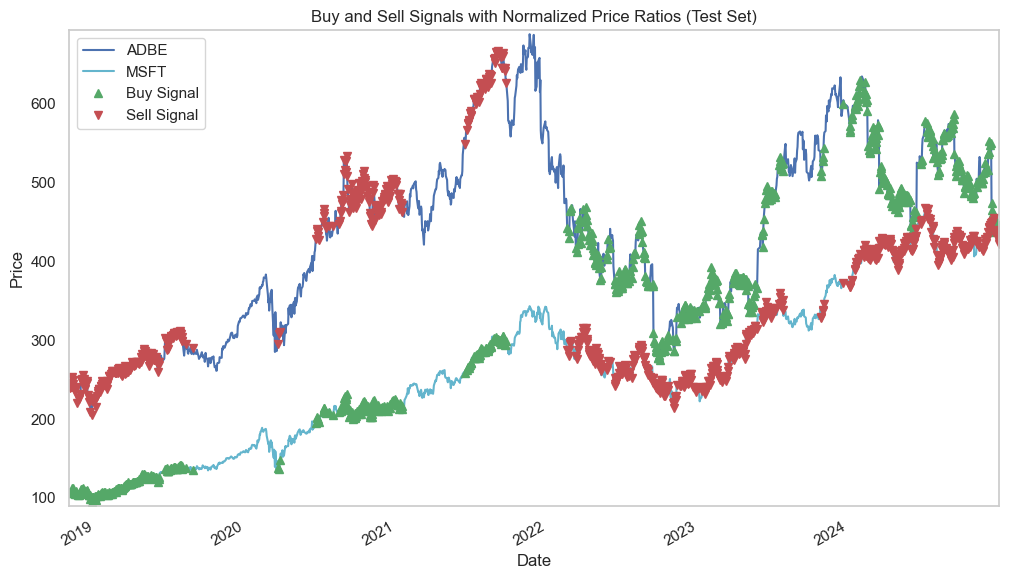

In [142]:
lower_threshold = -1
upper_threshold = 1 
test_data['normalised_ratios'] = (test_data['predicted_ratio'] - test_data['predicted_ratio'].mean())/test_data['predicted_ratio'].std()
test_data['buy_signal'] = (test_data['normalised_ratios'] < lower_threshold).astype(int)
test_data['sell_signal'] = (test_data['normalised_ratios'] > upper_threshold).astype(int)

# Extract signals
buy = test_data['buy_signal']
sell = test_data['sell_signal']

# Prepare plotting data
S1 = test_data['adobe_close']
S2 = test_data['microsoft_close']
buyR = 0 * S1.copy()
sellR = 0 * S1.copy()

# Assign buy and sell prices for visualization
buyR[buy != 0] = S1[buy != 0]
sellR[buy != 0] = S2[buy != 0]
buyR[sell != 0] = S2[sell != 0]
sellR[sell != 0] = S1[sell != 0]

# Plot the signals on the stock prices (Test Set)
plt.figure(figsize=(12, 7))
S1.plot(color='b', label='ADBE')
S2.plot(color='c', label='MSFT')
buyR.plot(color='g', linestyle='None', marker='^', label='Buy Signal')
sellR.plot(color='r', linestyle='None', marker='v', label='Sell Signal')

# Configure the axes and legend
plt.ylim(min(S1.min(), S2.min()) - 5, max(S1.max(), S2.max()) + 5)
plt.xlim(S1.index[0], S1.index[-1])
plt.legend()
plt.title('Buy and Sell Signals with Normalized Price Ratios (Test Set)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid()
plt.show()



In [143]:
def trade_with_hedging(S1, S2, predicted_ratios, window1, window2):
    # If window length is 0, the algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    # Compute rolling mean and rolling standard deviation using original price ratios
    ratios = S1 / S2
    ma1 = ratios.rolling(window=window1, center=False).mean()
    ma2 = ratios.rolling(window=window2, center=False).mean()
    std = ratios.rolling(window=window2, center=False).std()

    # Simulate trading with hedging
    money = 0  # Start with no money
    countS1 = 0  # Position in S1
    countS2 = 0  # Position in S2

    for i in range(len(ratios)):
        hedge_ratio = S1[i] / S2[i]  # Hedge ratio based on original price ratios (not normalized)

        # Use predicted ratio for decision making instead of z-score
        predicted_ratio = predicted_ratios[i]  # Use the predicted ratio for simulation

        # Sell S1 and buy S2 if predicted ratio > 1 (indicating S1 is overpriced relative to S2)
        if predicted_ratio > 1:
            money += S1[i] - S2[i] * hedge_ratio
            countS1 -= 1  # Short 1 unit of S1
            countS2 += hedge_ratio  # Long hedge_ratio units of S2

        # Buy S1 and sell S2 if predicted ratio < -1 (indicating S2 is overpriced relative to S1)
        elif predicted_ratio < -1:
            money -= S1[i] - S2[i] * hedge_ratio  # Combine money adjustment
            countS1 += 1  # Long 1 unit of S1
            countS2 -= hedge_ratio  # Short hedge_ratio units of S2

        # Clear positions if predicted ratio is between -0.75 and 0.75
        elif abs(predicted_ratio) < 0.75:
            money += countS1 * S1[i] + countS2 * S2[i]
            countS1 = 0  # Reset positions
            countS2 = 0

    return money


In [144]:

money = trade_with_hedging(S1=test_data['adobe_close'], S2=test_data['microsoft_close'], 
                           predicted_ratios=test_data['normalised_ratios'], window1=20, window2=60)

print(f"Total money after trading with hedging: {money}")


Total money after trading with hedging: 33842.0733179345
